<h1 align="center">Kalman Filter Demo</h1>

    David Morley
    
    January 18, 2020

The Kalman Filter is an algorithm for making smooth functions out of noisy data. This algorithm has applications any time you are working with observational data with any amount of noise. For example, the Kalman Filter was used in the guidance systems for the Apollo missions to the moon back in the 1960s. The system would use the algorithm to incorporate new positional data into a working model so that the astronauts could accurately predict where on Earth (or the Moon) they would land.  

In this demo, I code up several different algorithms for computing the Kalman Filter to compare their results. I also code up methods for using the filter to predict the future or past.

In [1]:
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
from scipy.linalg import sqrtm
from time import time

In [2]:
class LinearModel(object):
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F, self.Q, self.H, self.R, self.u, self.G = F, Q, H, R, u, np.eye(len(u))
            
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the linear system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        # Initialize oft used sizes
        self.n = len(x0)
        m = self.R.shape[0] 
        # Initialize storage spaces for states and obs
        states = np.zeros((self.n,N))
        states[:,0] = x0
        obs = np.zeros((m,N))
        # Run experiment
        for i in range(1,N):
            # Initialize noise terms
            w = np.random.multivariate_normal(np.zeros(self.n), self.Q)
            v = np.random.multivariate_normal(np.zeros(m), self.R)
            # Evolve state
            states[:,i] = self.F @ states[:,i-1] + self.G @ self.u + w
            obs[:,i] = self.H @ states[:,i-1] + v
        return states, obs
    
    def estimate(self,x0,P,y):
        """
        Compute the state estimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # Initialize starting values and objects
        n = len(x0)
        m,N = y.shape           
        out = np.zeros((n,N))
        out[:,0] = x0
        for i in range(N-1):
            yk = y[:,i].reshape((m,1))
            # Predict
            xk = self.F @ out[:,i].reshape((n,1)) + self.G @ self.u.reshape((n,1))                    
            Pk = self.F @ P @ self.F.T + self.Q
            # Update
            P = la.inv(la.inv(Pk) + self.H.T @ la.inv(self.R) @ self.H)
            out[:,i+1] = (xk - P @ self.H.T @ la.inv(self.R) @ (self.H @ xk - yk)).reshape(n)
            
        return out
    
    def KalmanFilter(self,x0,P,y):
        """
        Compute the state estimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        m, N = y.shape
        n = len(x0)   
        I = np.eye(n)
        out = np.zeros((n,N))
        out[:,0] = x0
        
        for i in range(N-1):
            yk = y[:,i].reshape((m,1))
            # Predict
            xk = self.F @ out[:,i].reshape((n,1)) + self.G @ self.u.reshape((n,1))                        
            Pk_1 = self.F @ P @ self.F.T + self.Q     
            # Update
            K = Pk_1 @ self.H.T @ la.inv(self.H @ Pk_1 @ self.H.T + self.R)
            out[:,i+1] = (xk + K @ (yk - self.H @ xk)).reshape(n)
            P = (I - K @ self.H) @ Pk_1

        return out    
        
    def predict(self, x, k):
        """
        Predict the next k states in the absence of observations.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state of the estimate.
        k : integer
            The number of states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        n = len(x)
        xk = np.zeros((n,k))
        xk[:,0] = x
        for i in range(k-1):
            xk[:,i+1] = self.F @ (xk[:,i] + self.u)
        return xk
        
    def rewind(self, x, k):
        """
        Predict the k states preceding the current state estimate x.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state of the estimate.
        k : integer
            The number of preceding states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        """
        n = len(x)
        xk = np.zeros((n,k))
        xk[:,0] = x
        for i in range(k-1):
            xk[:,i+1] = la.inv(self.F) @ (xk[:,i] - self.u)
        return xk
       
    def SquareRootFilter(self,x0,P,y):
        """
        Compute the state estimates using the square root filter algorithm.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        m, N = y.shape
        n = len(x0)   
        I = np.eye(n)
        out = np.zeros((n,N))
        # Step i
        out[:,0] = x0
        # Step ii
        S = la.cholesky(P)
        # Step iii
        for i in range(N-1):
            # Step iv
            T = sqrtm(self.Q)
            M = np.hstack([self.F @ S, T])
            # Step v
            S = la.cholesky(M @ M.T)
            # Step vi
            Pk = S @ S.T
            xk = self.F @ out[:,i] + self.G @ self.u
            # Step vii
            L = la.cholesky(self.H @ Pk @ self.H.T + self.R)
            V = la.cholesky(self.R)
            # Step viii
            S = S @ (I - S.T @ self.H.T @ la.inv(L).T @ la.inv(L + V) @ self.H @ S)
            # Step ix
            K = Pk @ self.H.T @ la.inv(L).T @ la.inv(L)
            # Step x
            out[:,i+1] = xk + K @ (y[:,i] - self.H @ xk)
            
        return out

In [28]:
def plotter(states,pred,x0,start,title,ylim,xlim):
    """Helper function to clean up code. Plots the predicted state sequence"""
    plt.plot(states[0,:],states[1,:],'b-',label='True Sequence')
    plt.plot(pred[0,:],pred[1,:],'k--',label='Prediction')
    if start:
        plt.plot(x0[0],x0[1],'k.',label='Start Point')
    plt.legend()
    plt.title(title)
    plt.ylim(ylim)
    plt.xlim(xlim)

def plotter1(obs, true, est, title):
    """Helper function to clean up code. Plots the whole observation sequence"""
    plt.plot(obs[0,:],obs[1,:],'r-',label='Observations')
    plt.plot(true[0,:],true[1,:],'b-',label='True Sequence')
    plt.plot(est[0,:],est[1,:],'g-', label='State Estimates')
    plt.title(title)
    plt.legend()
    
def plotter_zoom(obs, true, est):
    """Helper function to clean up code. Plots the part of an observation sequence"""
    plt.plot(obs[0,:150],obs[1,:150],'r.',label='Observations')
    plt.plot(true[0,250:300],true[1,250:300],'b-',label='True Sequence')
    plt.plot(est[0,:150],est[1,:150],'g-', lw=3, label='State Estimates')
    plt.legend()

The first step is to initialize our model. We are pretending that we can observe the location of a target along its trajectory with some noise. The first method in our class builds this environment for us. Essentially, the code accepts information about the world to incorporate into the model. Thus the $\Delta t$ represents our time step; In the $u$ vector $-9.8 \Delta t$ represents the force of gravity; The Q and R vectors represent our noise for different measurements (not a lot of noise in time, but an awful lot in position); and so on.

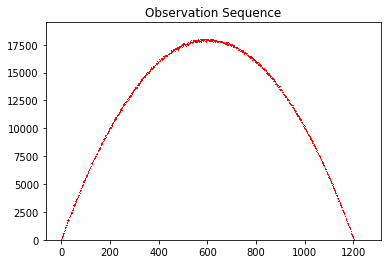

In [15]:
# Initialize given values
Δt = 0.1
F = np.array([[1,0,Δt,0],
              [0,1,0,Δt],
              [0,0, 1,0],
              [0,0, 0,1]])
H = np.array([[1,0,0,0],
              [0,1,0,0]])
u = np.array([0,0,0,-9.8*Δt])
Q, R = .1*np.eye(4), 5000*np.eye(2), 
x0 = np.array([0,0,300,600])
N = 1250
# Instantiate and run model
lm = LinearModel(F, Q, H, R, u)
states, obs = lm.evolve(x0,N)
# Plot results
xs = np.linspace(0,N,N)
plt.plot(obs[1,],'r,')
plt.title('Observation Sequence')
plt.ylim((0,19500))
plt.show()

We now compare three different implementations of the Kalman filter algorithm. They each do roughly the same things but are slightly different. The `estimate` method has the simplest code (and math) to follow. The `KalmanFilter` method is done in a computationally efficient way. And the `SquareRootFilter` method is much more numerically stable; that is it gives more accurate results with computer round-off error. Since this is a contrived system, we know exactly where the projectile should be at any given time. Thus we plot the true location in blue, the 'observed' locations in red, and the Kalman filter smoothed results in green.

Time of Basic Estimate Filter: 0.064 seconds.
Time of Kalman Filter: 0.038 seconds.
Time of Square Root Filter: 0.236 seconds.


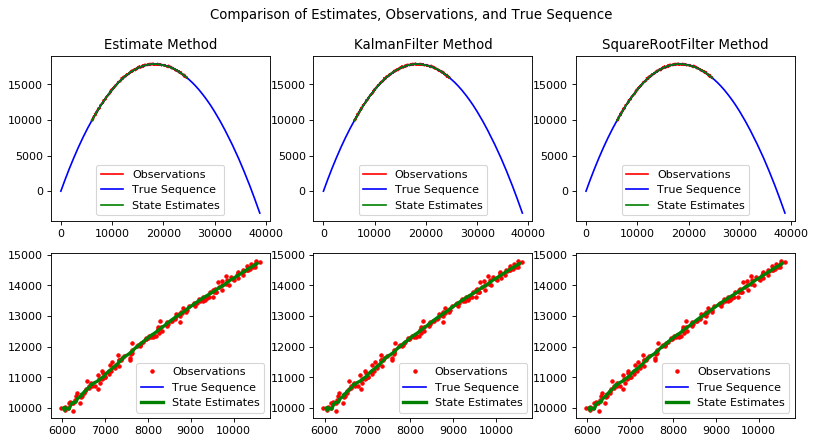

In [17]:
# Take a snippet of the full observation sequence to work with
snip = obs[:,200:800]
x200 = np.concatenate([snip[:,0],np.mean(np.diff(snip[:,:9]),axis=1)])
P200 = 1e6 * Q

# Time and save each of the different methods
start = time()
sqrt = lm.SquareRootFilter(x200,P200,snip)
sqrt_time = time() - start
start = time()
estimate = lm.estimate(x200,P200,snip)
est_time = time() - start
start = time()
kf = lm.KalmanFilter(x200,P200,snip)
kf_time = time() - start

print(f"Time of Basic Estimate Filter: {round(est_time,3)} seconds.")
print(f"Time of Kalman Filter: {round(kf_time,3)} seconds.")
print(f"Time of Square Root Filter: {round(sqrt_time,3)} seconds.")


fig=plt.figure(figsize=(12,6), dpi= 80, facecolor='w', edgecolor='k')
plt.suptitle('Comparison of Estimates, Observations, and True Sequence')
# Full plots
plt.subplot(231)
plotter1(snip, states, estimate,'Estimate Method')
plt.subplot(232)
plotter1(snip, states, kf,'KalmanFilter Method')
plt.subplot(233)
plotter1(snip, states, sqrt,'SquareRootFilter Method')

# Zoomed plots
plt.subplot(234)
plotter_zoom(snip, states, estimate)
plt.subplot(235)
plotter_zoom(snip, states, kf)
plt.subplot(236)
plotter_zoom(snip, states, sqrt)

plt.show()

They all look the same but I promise they're not. The algorithms increase in numeric stability from left to right. As you can see, the Square Root Filter adaptation of the Kalman Filter is the most stable algorithm, but it takes the longest to run.

Now we experiment with the filter's ability to use our model information and state observations to predict new states. Again, we plot the true state in blue to compare how close our estimation is.

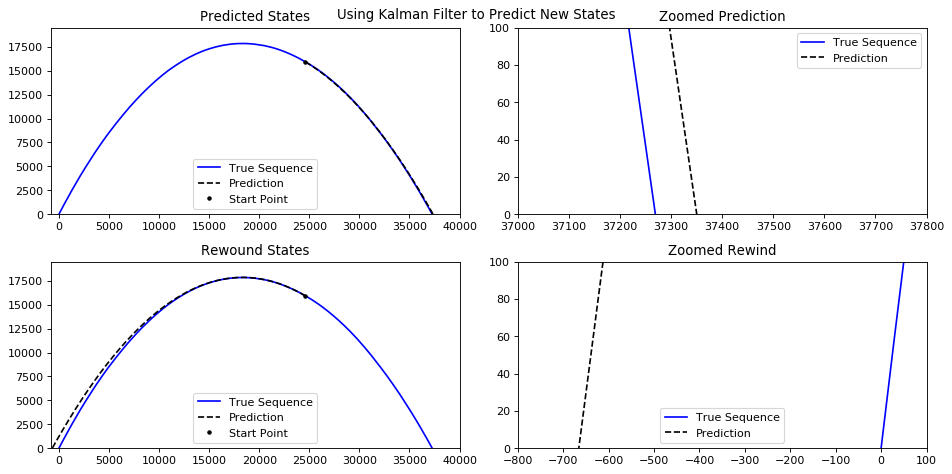

In [27]:
# Initialize systems
x0 = estimate[:,-1]
pred = lm.predict(x0,454)
rew = lm.rewind(x0,1000)

# And plot
fig=plt.figure(figsize=(12,6), dpi= 80, facecolor='w', edgecolor='k')
plt.suptitle('Using Kalman Filter to Predict New States')

# Plot Forecasted states
plt.subplot(221)
plotter(states,pred,x0,True,'Predicted States',(0,19500),(-800,40000))
plt.subplot(222)
plotter(states,pred,x0,False,'Zoomed Prediction',(0,100),(37000,37800))

# Plot Rewinded states
plt.subplot(223)
plotter(states,rew,x0,True,'Rewound States',(0,19500),(-800,40000))
plt.subplot(224)
plotter(states,rew,x0,False,'Zoomed Rewind',(0,100),(-800, 100))

plt.tight_layout()
plt.show()

As you can see, the Kalman filter does a very good job of accurately predicting the future (or past) given a current state. As the rewound example shows, the more the algorithm has to extrapolate, the more error that is introduced. However, the error seen is relatively minimal given that the dot has traveled 25,000 steps into the past and is less than 700 off of what it should be.